# ValueMeridian — Exploratory Data Analysis (EDA)

Denna notebook utforskar CSV-filen med sålda bostäder som genererats av vm-fetch och besvarar centrala frågor inom explorativ dataanalys (EDA):

- Vad innehåller datasetet (storlek, datatyper)?
- Finns det saknade värden?
- Förekommer det extremvärden eller avvikande observationer?
- Vilka samband finns mellan olika features och målvariabler?
- Hur stark är läget som signal?
- Finns det samband mellan mäklare/mäklarfirma och slutpris?

Antaganden:
- Sökväg till CSV-fil: data/partille_sold.csv (justera vid behov)
- Priser anges i SEK och ytor i m² (validerat vid datainläsning)

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import yaml

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


## Ladda data


In [183]:
# Resolve project root relative to this notebook
PROJECT_ROOT = Path.cwd()

if (PROJECT_ROOT / "pyproject.toml").exists() is False:
    PROJECT_ROOT = PROJECT_ROOT.parent

CSV_PATH = PROJECT_ROOT / "data" / "partille_raw.csv"
print(f"CSV Path: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
df.head()

MARKET_IDX_PATH = PROJECT_ROOT / "data" / "market_index.csv"
print(f"MARKET_IDX_PATH Path: {MARKET_IDX_PATH}")


POI_PATH = PROJECT_ROOT / "data" / "reference_points.yaml"
print(f"POI Path: {POI_PATH}")

with POI_PATH.open("r", encoding="utf-8") as f:
    poi_cfg = yaml.safe_load(f)

poi_list = poi_cfg["poi"]
# len(poi_list), [p["key"] for p in poi_list]

CSV Path: /Users/marcus/devmap/Python/YKPYT25H2/YKPYT25H2_PRJ1/data/partille_raw.csv
MARKET_IDX_PATH Path: /Users/marcus/devmap/Python/YKPYT25H2/YKPYT25H2_PRJ1/data/market_index.csv
POI Path: /Users/marcus/devmap/Python/YKPYT25H2/YKPYT25H2_PRJ1/data/reference_points.yaml


Point-Of-Interest (POI) visualisering

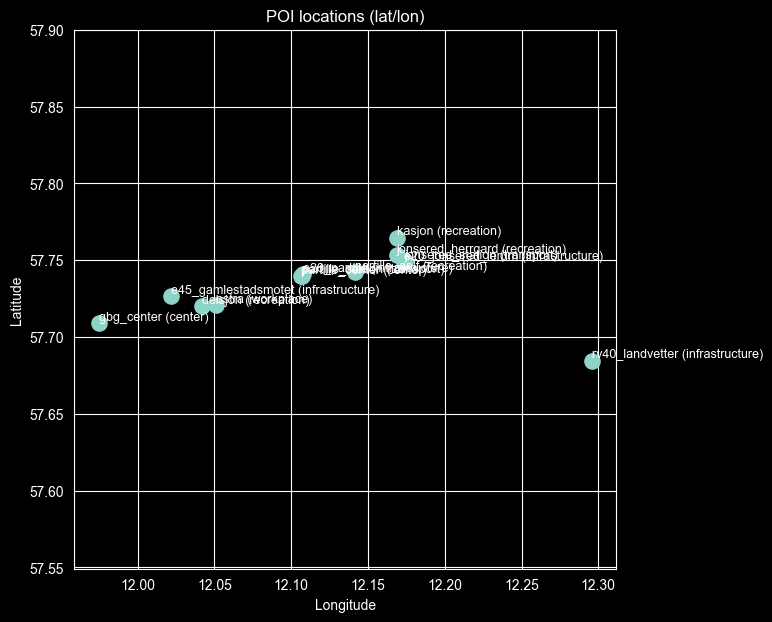

In [184]:
poi_df = pd.DataFrame(poi_list)

# Basic validation (helps catch typos in YAML)
required = {"key", "lat", "lon"}
missing_cols = required - set(poi_df.columns)
if missing_cols:
    raise ValueError(f"POI YAML is missing required fields: {sorted(missing_cols)}")

plt.figure(figsize=(7, 7))
plt.scatter(poi_df["lon"], poi_df["lat"], s=120)

for _, row in poi_df.iterrows():
    label = row["key"]
    # If you have 'category' in YAML, include it:
    if "category" in poi_df.columns and pd.notna(row.get("category")):
        label = f'{row["key"]} ({row["category"]})'

    plt.text(
        row["lon"],
        row["lat"],
        label,
        fontsize=9,
        ha="left",
        va="bottom"
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("POI locations (lat/lon)")
plt.grid(True)
plt.axis("equal")
plt.show()

Point-Of-Interest (POI) relativt sålda objekt

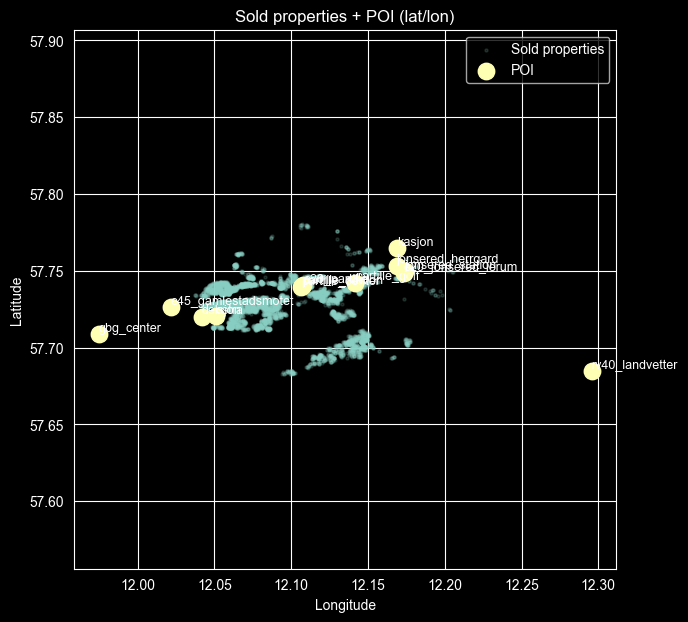

In [185]:
plt.figure(figsize=(7, 7))

# Background: sold properties (if df exists)
plt.scatter(
    df["longitude"],
    df["latitude"],
    s=5,
    alpha=0.15,
    label="Sold properties"
)

# Foreground: POI
plt.scatter(
    poi_df["lon"],
    poi_df["lat"],
    s=140,
    label="POI"
)

for _, row in poi_df.iterrows():
    plt.text(
        row["lon"],
        row["lat"],
        row["key"],
        fontsize=9,
        ha="left",
        va="bottom"
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Sold properties + POI (lat/lon)")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Dataset översikt

### Shape och kolumner


In [186]:
df.shape, list(df.columns)


((6580, 34),
 ['id',
  'sold_date',
  'sold_price_raw',
  'sold_sqm_price_raw',
  'list_price_raw',
  'first_price_raw',
  'object_type',
  'construction_year',
  'living_area_raw',
  'plot_area_raw',
  'rooms_raw',
  'operating_cost_raw',
  'street_address',
  'post_code',
  'named_areas',
  'municipality_name',
  'county_name',
  'latitude',
  'longitude',
  'area_country',
  'area_populated_area',
  'area_locality',
  'area_suburb',
  'area_user_defined',
  'area_index_area',
  'electricity_bidding_zone',
  'agent_id',
  'agent_name',
  'agent_recommendations',
  'agent_review_count',
  'agent_overall_rating',
  'agent_premium',
  'agency_id',
  'agency_name'])

### dtypes


In [187]:
df.dtypes


id                            int64
sold_date                    object
sold_price_raw                int64
sold_sqm_price_raw          float64
list_price_raw              float64
first_price_raw             float64
object_type                  object
construction_year           float64
living_area_raw             float64
plot_area_raw               float64
rooms_raw                   float64
operating_cost_raw          float64
street_address               object
post_code                     int64
named_areas                  object
municipality_name            object
county_name                  object
latitude                    float64
longitude                   float64
area_country                 object
area_populated_area          object
area_locality                object
area_suburb                  object
area_user_defined            object
area_index_area              object
electricity_bidding_zone     object
agent_id                    float64
agent_name                  

## Rätta datatyper
Vissa kolumner har fel datatyp efter inläsning från CSV.
Här korrigerar vi dessa.

In [188]:
df["id"] = df["id"].astype("string")

## Saknade värden


In [189]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

area_suburb              4725
area_locality            4628
operating_cost_raw       3479
agent_review_count       2584
agent_overall_rating     2584
agent_premium            2584
agent_id                 2584
agent_name               2584
agent_recommendations    2584
list_price_raw           2222
first_price_raw          2175
agency_id                1976
agency_name              1976
named_areas              1859
rooms_raw                1785
plot_area_raw             274
area_populated_area       249
area_user_defined         215
construction_year         190
living_area_raw            60
sold_sqm_price_raw         60
dtype: int64

## Fördelning av värden (nyckelvariabler)


### Sold price distribution (SEK)


In [190]:
df["sold_price_raw"].describe()

count    6.580000e+03
mean     4.739277e+06
std      1.888633e+06
min      5.000000e+04
25%      3.350000e+06
50%      4.550000e+06
75%      5.900000e+06
max      1.500000e+07
Name: sold_price_raw, dtype: float64

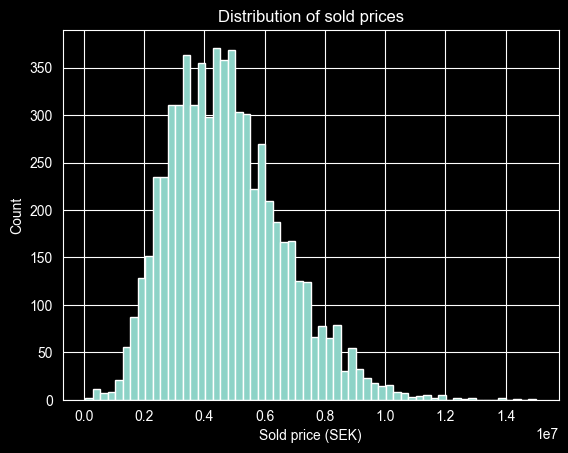

In [191]:
plt.figure()
plt.hist(df["sold_price_raw"].dropna(), bins=60)
plt.title("Distribution of sold prices")
plt.xlabel("Sold price (SEK)")
plt.ylabel("Count")
plt.show()

### Sold price per m² distribution (SEK/m²)


In [192]:
df["sold_sqm_price_raw"].describe()

count      6520.000000
mean      40917.269939
std       16446.445396
min         417.000000
25%       30000.000000
50%       39042.000000
75%       50248.750000
max      400333.000000
Name: sold_sqm_price_raw, dtype: float64

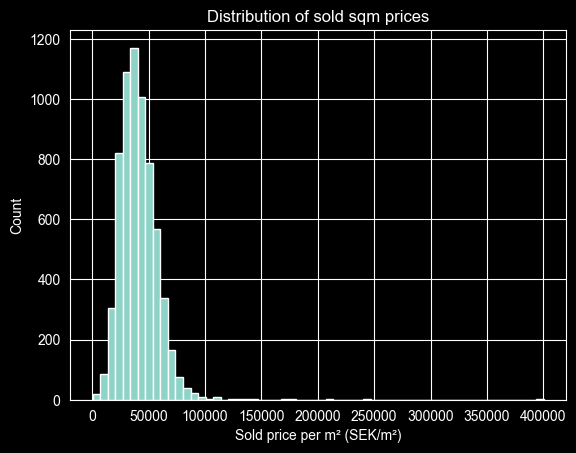

In [193]:
plt.figure()
plt.hist(df["sold_sqm_price_raw"].dropna(), bins=60)
plt.title("Distribution of sold sqm prices")
plt.xlabel("Sold price per m² (SEK/m²)")
plt.ylabel("Count")
plt.show()

### Living area distribution (m²)


In [194]:
df["living_area_raw"].describe()

count    6520.000000
mean      121.511534
std        41.092278
min        15.000000
25%        91.000000
50%       117.000000
75%       143.000000
max       494.000000
Name: living_area_raw, dtype: float64

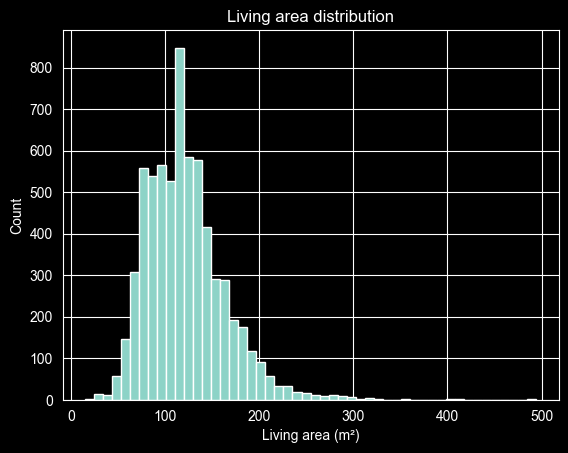

In [195]:
plt.figure()
plt.hist(df["living_area_raw"].dropna(), bins=50)
plt.title("Living area distribution")
plt.xlabel("Living area (m²)")
plt.ylabel("Count")
plt.show()

### Plot area distribution (m²)


In [196]:
df["plot_area_raw"].describe()

count      6306.000000
mean        679.166080
std        2120.908538
min           0.000000
25%         238.000000
50%         554.000000
75%         880.000000
max      156895.000000
Name: plot_area_raw, dtype: float64

### Ta bort negativa eller nollvärden, samt sannolikt orimliga världen för plot_area_raw
Negativa eller nollvärden, samt orimligt höga värden för tomtstorlek är inte meningsfulla i denna kontext, så vi filtrerar bort dessa rader.

In [197]:
df = df[df["plot_area_raw"] > 0]
df = df[df["plot_area_raw"] <= 10000]

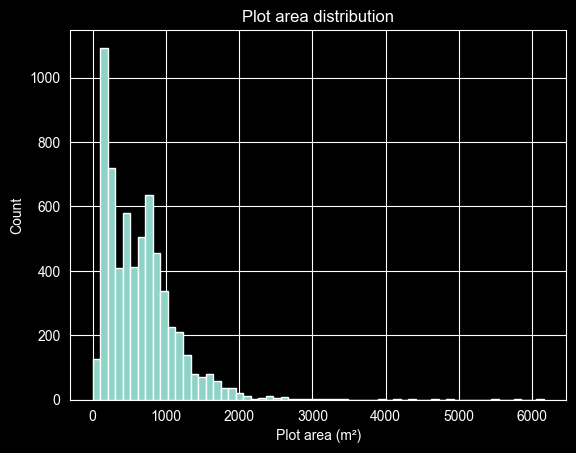

In [198]:
plt.figure()
plt.hist(df["plot_area_raw"].dropna(), bins=60)
plt.title("Plot area distribution")
plt.xlabel("Plot area (m²)")
plt.ylabel("Count")
plt.show()

## Sanity-check


### Sold price vs living area


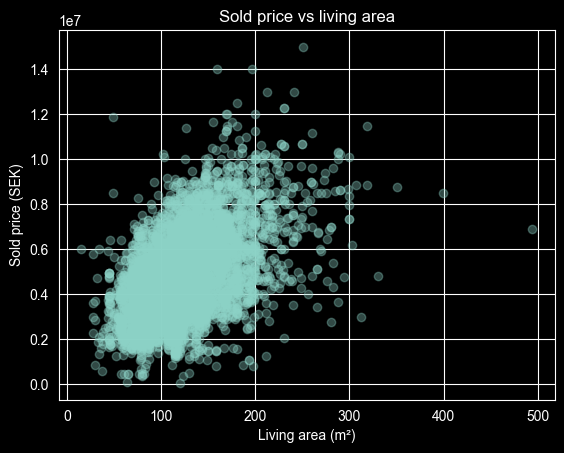

In [199]:
plt.figure()
plt.scatter(df["living_area_raw"], df["sold_price_raw"], alpha=0.35)
plt.title("Sold price vs living area")
plt.xlabel("Living area (m²)")
plt.ylabel("Sold price (SEK)")
plt.show()

### Sold sqm price vs construction year


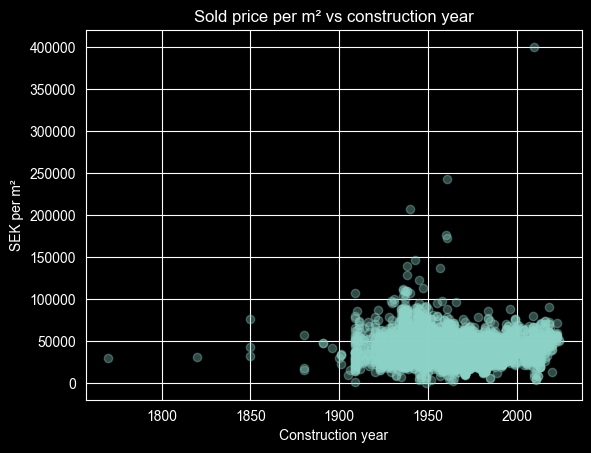

In [200]:
plt.figure()
plt.scatter(df["construction_year"], df["sold_sqm_price_raw"], alpha=0.35)
plt.title("Sold price per m² vs construction year")
plt.xlabel("Construction year")
plt.ylabel("SEK per m²")
plt.show()

## Feature engineering


In [201]:
# Använd max sold year för att beräkna husets ålder
max_year = pd.to_datetime(df["sold_date"], errors="coerce").dt.year.max()
df["house_age"] = max_year - df["construction_year"]
df = df.drop(columns=["construction_year"], errors="ignore")

# One-hot encodera object_type
df = pd.get_dummies(
    df,
    columns=["object_type"],
    prefix="type",
    drop_first=True
)
df = df.drop(columns=["object_type"], errors="ignore")

# Beräkna förhållandet mellan tomt och boyta
df["plot_living_ratio"] = df["plot_area_raw"] / df["living_area_raw"]

# Ta bort rader med noll eller negativa ytor för att undvika oändliga eller meningslösa värden i nya features
df = df[(df["plot_area_raw"] > 0) & (df["living_area_raw"] > 0)]

# Imputera saknade värden i house_age med medianen
df["house_age"] = df["house_age"].fillna(df["house_age"].median())

# Summera några av de nya features
df[["house_age", "plot_living_ratio", "rooms_raw"]].describe()

,house_age,plot_living_ratio,rooms_raw
count,6242.000000,6242.000000,4511.000000
mean,62.729414,5.582458,5.312569
std,23.685970,5.337376,1.399816
min,1.000000,0.005319,2.000000
25%,47.000000,2.326045,4.000000
50%,63.000000,4.785262,5.000000
75%,80.000000,6.998344,6.000000
max,255.000000,92.892857,17.000000


### Plot/living ratio vs sqm price


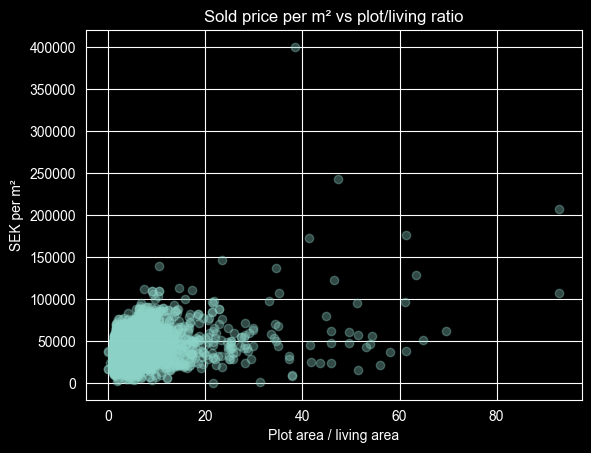

In [202]:
plt.figure()
plt.scatter(df["plot_living_ratio"], df["sold_sqm_price_raw"], alpha=0.35)
plt.title("Sold price per m² vs plot/living ratio")
plt.xlabel("Plot area / living area")
plt.ylabel("SEK per m²")
plt.show()

## Geografi — visualisera läge/prisspridning

En av de starkaste signalerna i bostadspriser är läget.
Här utforskar vi lägesdata med enkla visualiseringar och avståndsberäkningar.


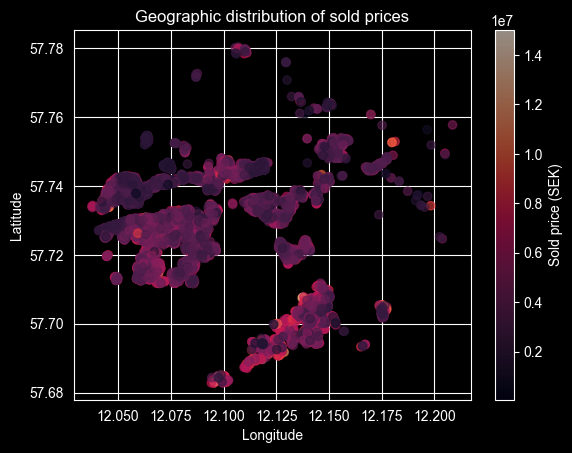

In [203]:
plt.figure()
sc = plt.scatter(df["longitude"], df["latitude"], c=df["sold_price_raw"], alpha=0.6)
plt.colorbar(sc, label="Sold price (SEK)")
plt.title("Geographic distribution of sold prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Avstånd till viktiga referenspunkter (haversine)

Avstånd till centrala platser kan vara en stark signal för bostadspriser.
Här beräknar vi avstånd till de Point-Of-Interest (POI) som definierats i YAML-filen.
Avstånd beräknas med Haversine-formeln som ger storcirkelavstånd mellan två punkter (fågelvägen) på jordens yta.
Även om detta inte tar hänsyn till verkliga vägar eller terräng, är det förhoppningsvis en användbar approximation för geografiska analyser.

*Avstånden läggs till som nya kolumner i DataFrame:en med namngivningskonventionen dist_{poi_key}_km.*




In [204]:
def haversine_vec(lat, lon, ref_lat, ref_lon):
    R = 6371.0
    lat1 = np.radians(lat.astype(float))
    lon1 = np.radians(lon.astype(float))
    lat2 = np.radians(float(ref_lat))
    lon2 = np.radians(float(ref_lon))

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def distance_feature(lat_series, lon_series, ref_lat, ref_lon, decimals=1):
    return np.round(haversine_vec(lat_series, lon_series, ref_lat, ref_lon), decimals)

df = df.copy()

df["latitude"] = df["latitude"].astype(float)
df["longitude"] = df["longitude"].astype(float)

DIST_DECIMALS = 1  # keep consistent with training & inference

for poi in poi_list:
    key = poi["key"]
    ref_lat = poi["lat"]
    ref_lon = poi["lon"]

    col_name = f"dist_{key}_km"

    df[col_name] = distance_feature(
        df["latitude"],
        df["longitude"],
        ref_lat,
        ref_lon,
        decimals=DIST_DECIMALS
    )

# Verifiera att kolumnerna har lagts till
sorted(c for c in df.columns if c.startswith("dist_"))

poi_by_category = defaultdict(list)
for p in poi_list:
    poi_by_category[p["category"]].append(p["key"])

# Beräkna minsta avstånd per kategori som feature
for category, keys in poi_by_category.items():
    cols = [f"dist_{k}_km" for k in keys if f"dist_{k}_km" in df.columns]
    if cols:
        df[f"min_dist_{category}_km"] = df[cols].min(axis=1)

df.filter(like="dist_").describe()

df[["sold_price_raw"] + [c for c in df.columns if c.startswith("dist_")]] \
    .corr()["sold_price_raw"].sort_values()

dist_rv40_landvetter_km       -0.112825
dist_ostra_km                 -0.073845
dist_gbg_center_km            -0.061574
dist_delsjon_km               -0.059719
dist_e45_gamlestadsmotet_km    0.003164
dist_e20_jonsered_lerum_km     0.147352
dist_jonsered_station_km       0.150654
dist_partille_golf_km          0.166646
dist_jonsered_herrgard_km      0.175977
dist_partille_center_km        0.180934
dist_partille_station_km       0.185082
dist_e20_partille_km           0.196064
dist_kasjon_km                 0.219257
sold_price_raw                 1.000000
Name: sold_price_raw, dtype: float64

## Avstånd till POI kategori realtivt kvadratmeterpris

In [205]:
rows = []
poi_cols = [c for c in df.columns if c.startswith("dist_")]

for col in poi_cols:
    near = df[df[col] < df[col].median()]["sold_sqm_price_raw"]
    far = df[df[col] >= df[col].median()]["sold_sqm_price_raw"]

    rows.append({
        "poi": col,
        "near_mean": near.mean(),
        "far_mean": far.mean(),
        "diff_pct": (near.mean() - far.mean()) / far.mean() * 100
    })

effect_df = pd.DataFrame(rows).sort_values("diff_pct", ascending=False)

import numpy as np
import pandas as pd

# effect_df expected columns: poi, near_mean, far_mean, diff_pct

out = effect_df.copy()

# Make it nicer: rename POI column (optional)
out["poi"] = out["poi"].str.replace("^dist_", "", regex=True).str.replace("_km$", "", regex=True)

# Add absolute SEK difference too
out["diff_sek"] = out["near_mean"] - out["far_mean"]

# Round numeric columns
out["near_mean"] = out["near_mean"].round(0).astype("Int64")
out["far_mean"]  = out["far_mean"].round(0).astype("Int64")
out["diff_sek"]  = out["diff_sek"].round(0).astype("Int64")
out["diff_pct"]  = out["diff_pct"].round(1)

# Add interpretation text
def interpret(diff_pct: float) -> str:
    if pd.isna(diff_pct):
        return ""
    # positive => near higher price
    direction = "Närmare → högre pris" if diff_pct > 0 else "Närmare → lägre pris"
    strength = (
        "svag" if abs(diff_pct) < 2 else
        "måttlig" if abs(diff_pct) < 6 else
        "tydlig"
    )
    return f"{direction} ({strength} effekt)"

out["tolkning"] = out["diff_pct"].apply(interpret)

# Reorder columns
out = out[["poi", "near_mean", "far_mean", "diff_sek", "diff_pct", "tolkning"]]

out.head(15)


,poi,near_mean,far_mean,diff_sek,diff_pct,tolkning
1,gbg_center,44534,37768,6766,17.9,Närmare → högre pris (tydlig effekt)
9,delsjon,44518,37781,6737,17.8,Närmare → högre pris (tydlig effekt)
4,ostra,44547,37953,6594,17.4,Närmare → högre pris (tydlig effekt)
6,e45_gamlestadsmotet,44073,38436,5637,14.7,Närmare → högre pris (tydlig effekt)
8,rv40_landvetter,38855,43315,-4460,-10.3,Närmare → lägre pris (tydlig effekt)
0,partille_center,38470,43780,-5310,-12.1,Närmare → lägre pris (tydlig effekt)
5,e20_partille,38465,43804,-5340,-12.2,Närmare → lägre pris (tydlig effekt)
2,partille_station,38329,43837,-5508,-12.6,Närmare → lägre pris (tydlig effekt)
11,partille_golf,37730,44459,-6729,-15.1,Närmare → lägre pris (tydlig effekt)
3,jonsered_station,37570,44385,-6815,-15.4,Närmare → lägre pris (tydlig effekt)


## Konvertera data

In [206]:
# Konvertera sold_date till datetime och extrahera år/månad
df["sold_date"] = pd.to_datetime(df["sold_date"], errors="coerce")
df["sold_year"] = df["sold_date"].dt.year
df["sold_month"] = df["sold_date"].dt.month

# Fyll i saknade värden i operating_cost_raw med medianen
df["operating_cost_raw"] = df["operating_cost_raw"].fillna(
    df["operating_cost_raw"].median()
)

### Ta bort kolumner som inte är numeriska eller inte användbara för modellering

In [207]:
df = df.drop(columns=["id"], errors="ignore")

# Fält med hög kardinalitet och låg generaliserbarhet
df = df.drop(columns=["street_address"], errors="ignore")
df = df.drop(columns=["post_code"], errors="ignore")

# ID/namen är kategoriska utan ordning, risk för att modellen “lär sig” historik istället för egenskaper
df = df.drop(columns=["agent_id"], errors="ignore")
df = df.drop(columns=["agent_name"], errors="ignore")
df = df.drop(columns=["agency_id"], errors="ignore")
df = df.drop(columns=["agency_name"], errors="ignore")

# Sold date är nu representerat med år/månad
df = df.drop(columns=["sold_date"], errors="ignore")

# Geografiska kategorier med hög kardinalitet
df = df.drop(columns=["named_areas"], errors="ignore")
df = df.drop(columns=["area_user_defined"], errors="ignore")
df = df.drop(columns=["area_locality"], errors="ignore")
df = df.drop(columns=["area_suburb"], errors="ignore")
df = df.drop(columns=["area_index_area"], errors="ignore")
df = df.drop(columns=["area_country"], errors="ignore")
df = df.drop(columns=["area_populated_area"], errors="ignore")
df = df.drop(columns=["electricity_bidding_zone"], errors="ignore")

# Administrativa begrepp med låg generaliserbarhet (Konstant eller nästan konstant i datasetet)
df = df.drop(columns=["municipality_name"], errors="ignore")
df = df.drop(columns=["county_name"], errors="ignore")

# Ta bort råa prisfält som inte behövs längre
df = df.drop(columns=["list_price_raw"], errors="ignore")
df = df.drop(columns=["first_price_raw"], errors="ignore")

# Ta bort Agent data då dessa kan lära modellen oönskade mönster.
# t ex vilka mäklare som säljer dyra objekt snarare än varför objektet är dyrt
df = df.drop(columns=["agent_recommendations"], errors="ignore")
df = df.drop(columns=["agent_review_count"], errors="ignore")
df = df.drop(columns=["agent_overall_rating"], errors="ignore")
df = df.drop(columns=["agent_premium"], errors="ignore")

# sold_sqm_price_raw är härledd från sold_price_raw och living_area_raw, så vi kan ta bort den också
df = df.drop(columns=["sold_sqm_price_raw"], errors="ignore")

# Imputera saknade värden i rooms_raw med medianen baserat på object_type
#df["rooms_raw"] = (
#    df.groupby(["type_Villa", "type_Radhus", "type_Parhus"])["rooms_raw"]
#      .transform(lambda s: s.fillna(s.median()))
#)

# Saknade värden i rooms_raw indikeras med en ny binär feature
df["rooms_missing"] = df["rooms_raw"].isna().astype(int)
df["rooms_raw"] = df["rooms_raw"].fillna(0)


## Korrelationsanalys mellan numeriska features och målvariabler

Tolkning (tumregler):
- |corr| > 0.7 → stark
- 0.3–0.7 → måttlig
- < 0.3 → svag

In [208]:
TARGET = "sold_price_raw"

numeric_df = df.select_dtypes(include=[np.number])
corr_with_target = numeric_df.corr()[TARGET].sort_values(ascending=False)
corr_with_target

sold_price_raw                 1.000000
sold_year                      0.601452
living_area_raw                0.502454
plot_area_raw                  0.296261
min_dist_infrastructure_km     0.229788
dist_kasjon_km                 0.219257
min_dist_transport_km          0.206185
dist_e20_partille_km           0.196064
dist_partille_station_km       0.185082
dist_partille_center_km        0.180934
min_dist_center_km             0.180895
dist_jonsered_herrgard_km      0.175977
rooms_raw                      0.173803
dist_partille_golf_km          0.166646
operating_cost_raw             0.160566
dist_jonsered_station_km       0.150654
dist_e20_jonsered_lerum_km     0.147352
min_dist_recreation_km         0.124586
plot_living_ratio              0.017566
longitude                      0.008901
dist_e45_gamlestadsmotet_km    0.003164
sold_month                    -0.007357
rooms_missing                 -0.007743
dist_delsjon_km               -0.059719
dist_gbg_center_km            -0.061574


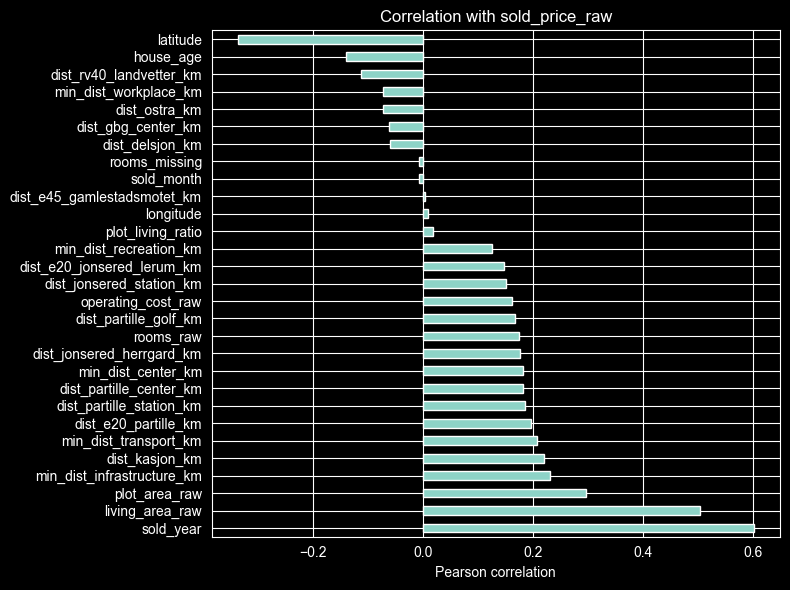

In [209]:
import matplotlib.pyplot as plt

corr_with_target.drop(TARGET).plot(
    kind="barh",
    figsize=(8, 6),
    title="Correlation with sold_price_raw"
)
plt.xlabel("Pearson correlation")
plt.tight_layout()
plt.show()


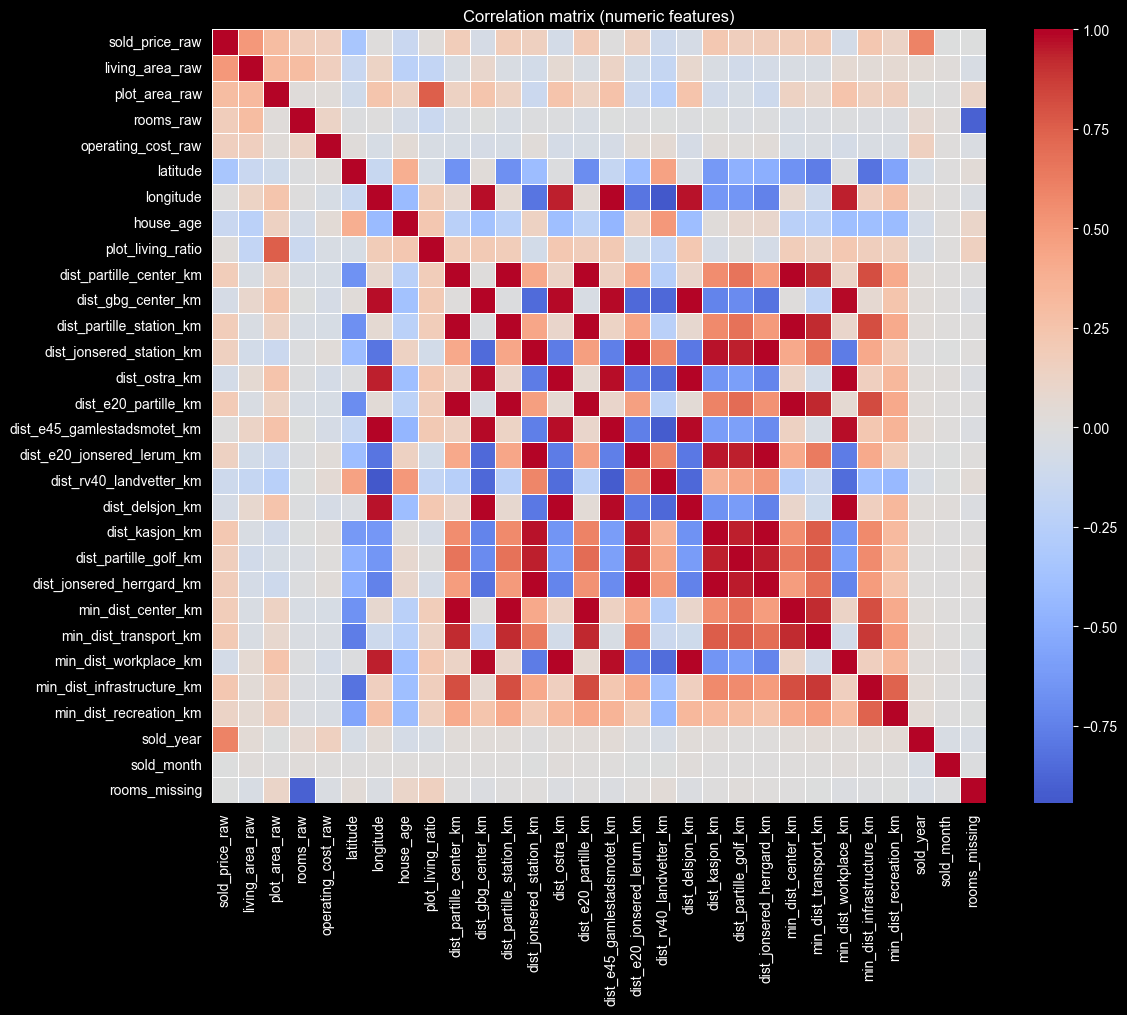

In [210]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(
    numeric_df.corr(),
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()

## Slutlig kontroll av saknade värden

In [211]:
df.isna().sum().sort_values(ascending=False).head(30)

sold_price_raw                 0
dist_e20_partille_km           0
sold_month                     0
sold_year                      0
min_dist_recreation_km         0
min_dist_infrastructure_km     0
min_dist_workplace_km          0
min_dist_transport_km          0
min_dist_center_km             0
dist_jonsered_herrgard_km      0
dist_partille_golf_km          0
dist_kasjon_km                 0
dist_delsjon_km                0
dist_rv40_landvetter_km        0
dist_e20_jonsered_lerum_km     0
dist_e45_gamlestadsmotet_km    0
dist_ostra_km                  0
living_area_raw                0
dist_jonsered_station_km       0
dist_partille_station_km       0
dist_gbg_center_km             0
dist_partille_center_km        0
plot_living_ratio              0
type_Villa                     0
type_Radhus                    0
type_Parhus                    0
house_age                      0
longitude                      0
latitude                       0
operating_cost_raw             0
dtype: int

## Exportera den förädlade datan (inkl. feature engineering)


In [169]:
OUTPUT_PATH = PROJECT_ROOT / "data" / "partille_sold_eda.csv"

df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8", lineterminator="\n")
print(f"Saved cleaned EDA dataset to: {OUTPUT_PATH}")


Saved cleaned EDA dataset to: /Users/marcus/devmap/Python/YKPYT25H2/YKPYT25H2_PRJ1/data/partille_sold_eda.csv
